In [2]:
import tensorflow as tf
import numpy as np
import math
na = np.newaxis
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

import time, os

# import helper functions from utils.py:
from utils import get_lower_test_bound, get_run_prefix, ard_kernel, build_2d_grid, train_parameters, evaluation, tf_tril_indices, load_lookup_table, table_lookup_op_parallel, get_scp_samples, build_graph, build_eval_graph, get_test_log_likelihood
from generative_model import inhomogeneous_poisson_process_g2

# Planning:

- test on simple example and compare real / optimized distributions (define real dist-> sample data -> calc approx -> compare)
- test on real dataset

### BUGS:
- urgent: logdet calculation gives Nans, current fix: replace the zeros by eye in the sparse add, does not solve it in any case however

-> try: does it work with decomp and I stabilizer?

- m and S values go to infinity if inducing_point_res >= 9


### TODOS:
- lower bound >0 ???
- Check T region definition (currently limits of inducing points)
- calculate and print lower bound for testset
- improve 2d sampling function
- optimize Lookup Table resolution (Max)

# 2d example

In [3]:
from scipy.stats import multivariate_normal

def double_blob(x):
    blob_1 = multivariate_normal.pdf(x, mean = [3, 3], cov=[[1, 0], [0, 1]])
    blob_2 = multivariate_normal.pdf(x, mean = [7, 7], cov=[[1, 0], [0, 1]])
    return (blob_1 + blob_2) * 10

def gram_matrix(xs):
    return np.array([[ard_kernel(x1,x2) for x2 in xs] for x1 in xs])

def ard_kernel(x1,x2):
    R = 2
    a = np.ones([R])*5
    g = 0.7
    return g * np.prod([np.exp(-1 * ((x1-x2) ** 2) / (2 * a[r])) for r in range(R)])

def gaussian_process_rate_function(xs):
    mean = [0 for x in xs]
    gram = gram_matrix(xs)
    result = np.random.multivariate_normal(mean, gram)**2

    return result

In [4]:
get_fun_from_file = True

upper_bound = 2
Tlims = np.array([[0., 10.], [0., 10.]])
res = 60
lam_star = 20.
params = np.array([2.,1.5])
num_test_sets = 1

if not get_fun_from_file:

    #generate samples
    #samples,test_samples, _,xx, yy,vals = get_scp_samples(gaussian_process_rate_function, Tlims, upper_bound,res)
    #plot_vals = vals.reshape(res,res)
    
    the_dict = {'X_sets':X_sets, 'intensity_sets': intensity_sets, 'X_grid':X_grid, 'intensity_array':intensity_array}
    X_sets, intensity_sets, X_grid, intensity_array = inhomogeneous_poisson_process_g2(Tlims, lam_star, 'ard',
                                         params, grid_points=res, seed=None,
                                         num_sets=1 + num_test_sets)  
    np.savez('current_reference_function', **the_dict)

else:
    loaded_dict = (dict(np.load('current_reference_function.npz')))
    locals().update(loaded_dict)

samples = X_sets[0]
test_samples = X_sets[1:]
plot_vals = intensity_array
vals = intensity_array
xx,yy = np.meshgrid(X_grid[:,0],X_grid[:,1])

Train set size: (263, 2)


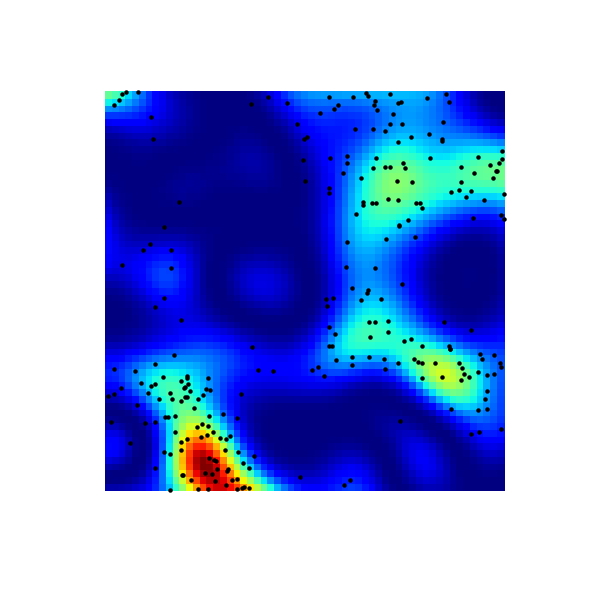

In [5]:
print('Train set size: {}'.format(samples.shape))

#plot the rate_function over a grid
plt.figure(figsize=(10,10))
plt.pcolormesh(xx, yy, intensity_array.reshape(res,res))
plt.scatter(samples[:,0], samples[:,1], linewidth=0, c='black', s=20)
# plt.colorbar()
plt.axis('off')
plt.savefig('gt_with_data', dpi=300)
plt.show()

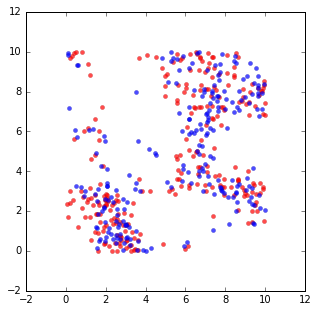

(263, 2)


In [7]:
# sampled data:
plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1], linewidth=0.1, alpha=.7, c='r')
plt.scatter(test_samples[0][:,0], test_samples[0][:,1], linewidth=0.1, alpha=.7, c='b')
plt.show()

print(samples.shape)

# Variational Approximation

In [6]:
def ard_kernel_bc(X1, X2, gamma=1, alphas=None):
    if len(X1.shape) == 1:
        X1 = X1[:, None]
    if len(X2.shape) == 1:
        X2 = X2[:, None]
    assert(X1.shape[1] == X2.shape[1])
    
    if alphas is None:
        alphas = np.ones(X1.shape[1])
    return gamma * np.prod(np.exp(- (X1[:, None, :] - X2[None,:,:])**2 / (2 * alphas[None, None, :])), axis=2)

### 2D Parameter Learning

In [24]:
## ######## ##
# PARAMETERS #
## ######## ##

tf.logging.set_verbosity(tf.logging.DEBUG)
check_numerics = False
init_debug     = False
prelog_debug   = False
tb_summary     = True

# general options
train_hyperparameters    = False
optimize_inducing_points = False
ind_point_num            = 8

stabilizer_value     = 1e-7
kzz_stabilizer_value = 1e-7

# gradient descent options
optimizer = 'vanilla' # options: 'vanilla' | 'adam' | 'momentum'

max_iterations = 1000
chk_iterations = 1001
learning_rate  = 1e-2
convergence_threshold = 1e-7

# initialization:
m_init_val        = 0.01
init_S_as_eye     = False


alphas_init = [1.5,  1.5]
gamma_init  = 2.
ag_poser = 'abs'

# tensorboard options:
log_dir    = 'logs/2d_example_optimizers'
run_prefix = get_run_prefix(optimize_inducing_points, train_hyperparameters, optimizer, ind_point_num, max_iterations, learning_rate, gamma_init, alphas_init)


# build_evaluation_gridl
eval_res = 100
eval_grid = build_2d_grid(Tlims, eval_res)

strt = time.time()
        
m_opt, S_opt, Kzz_inv_opt, alphas_opt, Z_opt,gamma_opt, lb_val = train_parameters(samples,
                                                                          ind_point_number         = ind_point_num, 
                                                                          Tlims                    = Tlims, 
                                                                          optimize_inducing_points = optimize_inducing_points, 
                                                                          train_hyperparameters    = train_hyperparameters, 
                                                                          learning_rate            = learning_rate, 
                                                                          optimizer                = optimizer,
                                                                          max_iterations           = max_iterations, 
                                                                          convergence_threshold    = convergence_threshold,
                                                                          chk_iters                = chk_iterations,
                                                                          gamma_init               = gamma_init, 
                                                                          alphas_init              = alphas_init,
                                                                          ag_poser                 = ag_poser,
                                                                          init_S_as_eye            = init_S_as_eye,
                                                                          log_dir                  = log_dir, 
                                                                          check_numerics           = check_numerics,
                                                                          stabilizer_value         = stabilizer_value,
                                                                          kzz_stabilizer_value     = kzz_stabilizer_value,
                                                                          enable_initialization_debugging = init_debug,
                                                                          enable_pre_log_debugging        = prelog_debug,
                                                                          write_tensorboard_summary = tb_summary,
                                                                          run_prefix = run_prefix
                                                                                 ) 
lam_vals, lam_var = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt, eval_grid)

stp = time.time()
print('Finished optimization + evaluation in {:3f}s'.format(stp-strt))

Begin training with 8 inducing points
Inducing Point optimization = False
Finished optimization in 86.40060067176819s
Finished optimization + evaluation in 100.857206s


In [17]:
print(np.min(lam_var))

0.0527518689336


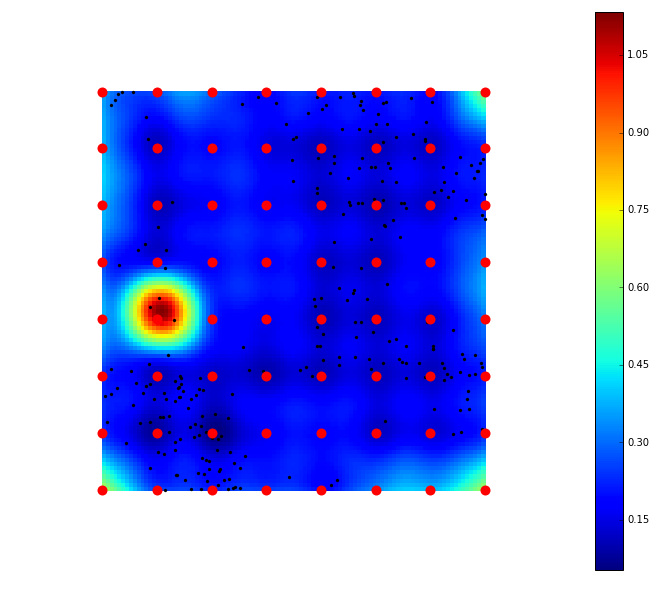

In [18]:
folder_path = log_dir + '/' + run_prefix + '/'

plt.figure(figsize=(12, 10))

xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], eval_res), np.linspace(Tlims[1,0], Tlims[1,1], eval_res))
# norm = mpl.colors.Normalize(vmin=np.min(lam_var), vmax=0.6)

plt.pcolormesh(xx, yy, lam_var.reshape(eval_res, eval_res), cmap='jet')
plt.colorbar()

plt.scatter(samples[:,0], samples[:,1], marker='.', c='black', s=40, linewidth=0.1)
plt.scatter(Z_opt[:, 0], Z_opt[:,1], marker='o', c='r', s=100, linewidth=0.)
plt.axis('off')
plt.savefig(folder_path + 'variance.png', dpi=300)
plt.show()

In [19]:
test_bounds = np.array([np.squeeze(get_lower_test_bound(tst_smpls, m_opt, S_opt, Kzz_inv_opt, alphas_opt, gamma_opt, Z_opt)) for tst_smpls in test_samples])
lam_x_mean, lam_x_var = evaluation(m_opt,S_opt,Kzz_inv_opt,alphas_opt,gamma_opt,Z_opt, samples)

RMSE = np.sqrt( np.mean( (intensity_sets[0] - lam_x_mean)**2 ) )

print(RMSE)

2.1019022034


Lower Bound (TRAIN): [ 78.50333251]
Lower Bound (TEST, averaged over 1 sets) : 33.31531207351236
alphas:  [ 1.5  1.5]
gamma:  2.0


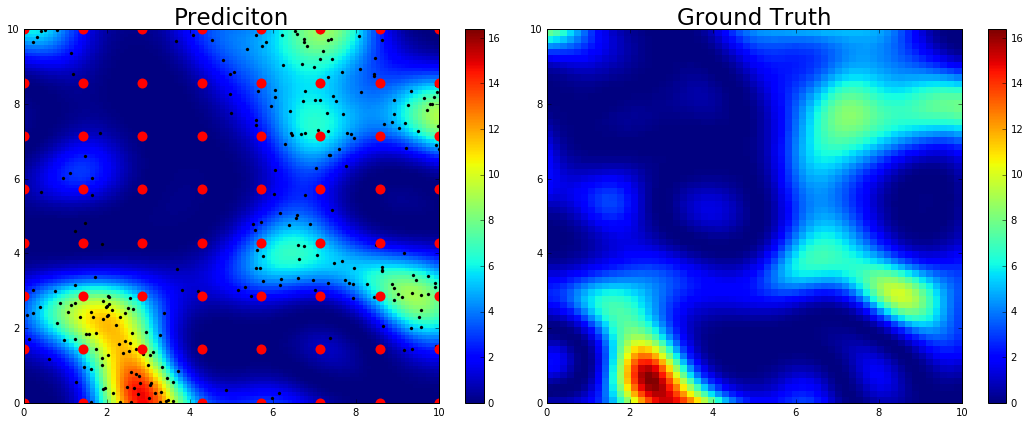

In [20]:
# present and save results

fntsz = 23

lbtrain = lb_val[0]
lbtest  = np.mean(test_bounds)

print('Lower Bound (TRAIN): {}'.format(lb_val[0]))
print('Lower Bound (TEST, averaged over {} sets) : {}'.format(test_bounds.shape[0], lbtest))

fig = plt.figure(figsize=(15, 6)) 
max_value = np.max([np.max(vals), np.max(lam_vals)])
norm = mpl.colors.Normalize(vmin=0, vmax=max_value)

#print("ind point number: ",i)
print("alphas: ",alphas_opt)
print("gamma: ",gamma_opt)

# plt.title('LBTrain: {}, LBTest: {}, RMSE: {}'.format(lbtrain, lbtest, RMSE), size=200)

xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], eval_res), np.linspace(Tlims[1,0], Tlims[1,1], eval_res))

ax0 = plt.subplot(1,2,1)
im = ax0.pcolormesh(xx, yy, lam_vals.reshape(eval_res, eval_res),  norm=norm)
fig.colorbar(im, ax=ax0)
ax0.set_title('Prediction', size=fntsz)
ax0.scatter(samples[:,0], samples[:,1], marker='.', c='black', s=40, linewidth=0.1)
ax0.scatter(Z_opt[:, 0], Z_opt[:,1], marker='o', c='r', s=100, linewidth=0.)

plt.xlim(Tlims[0,0], Tlims[0,1])
plt.ylim(Tlims[1,0], Tlims[1,1])

xx, yy = np.meshgrid(np.linspace(Tlims[0,0], Tlims[0,1], res), np.linspace(Tlims[1,0], Tlims[1,1], res))

ax1 = plt.subplot(1,2, 2)
im1 = ax1.pcolormesh(xx, yy, plot_vals, norm=norm)
fig.colorbar(im1, ax=ax1)
ax1.set_title('Ground Truth', size=fntsz)
# ax1.scatter(Z_opt[:, 0], Z_opt[:,1], marker='+', c='r', s=10000)
plt.xlim(Tlims[0,0], Tlims[0,1])
plt.ylim(Tlims[1,0], Tlims[1,1])

result_dict = {'vals':vals, 'lam_vals':lam_vals, 'alphas_opt':alphas_opt, 'gamma_opt':gamma_opt, 'Z_opt':Z_opt, 'm_opt':m_opt, 'S_opt':S_opt,
         'train_samples':samples, 'test_samples':test_samples, 'learning_rate':learning_rate, 'lb_train':lbtrain, 'lb_test':lbtest, 'rmse':RMSE}

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.tight_layout()
plt.savefig(folder_path + 'result.png', dpi=300)
np.savez(   folder_path + 'values', **result_dict)

plt.show()